In [1]:
import numpy as np
import pandas as pd
from NeuralNetwork import *
from utils import *
import warnings
# to ignore pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)

r: 0.2093634372591784 
 TS:0.566661045025105
CPU times: user 41min 43s, sys: 4.37 s, total: 41min 47s
Wall time: 41min 47s


'\nr: 0.20404438803103606 \n TS:0.5661773459813595\n'

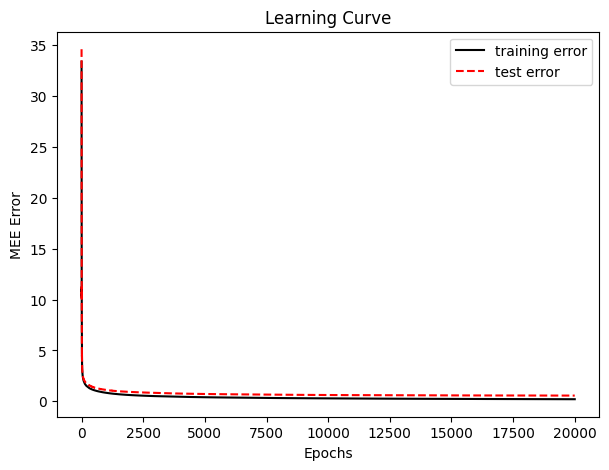

In [1]:
%%time
import numpy as np
import pandas as pd
from utils import *
import warnings
# to ignore pandas warning
warnings.simplefilter(action='ignore', category=FutureWarning)
import NeuralNetwork
import matplotlib.pyplot as plt



col_names = ('Input1', 'Input2', 'Input3', 'Input4', 'Input5', 'Input6',
             'Input7', 'Input8', 'Input9', 'Input10', 'TARGET_x', 'TARGET_y', 'TARGET_z')
data = pd.read_csv("../ML-23-PRJ-Package/ML-CUP23-TR.csv",
                   skiprows=7, usecols=[i for i in range(1, 14)], names=col_names)

data = data.sample(frac=1)
#SPLIT 80/20 FOR TRAIN/TEST
folds = np.array_split(data,10 )
tr_data = pd.concat(folds[1:10])
test_data = pd.concat(folds[0:1])

params =  {'eta': 0.00001, 'mb': 32, 'momentum': 0.99, 'n_layers': 15, 'n_neurons': 500, 'epochs': 20000, 'clip_value': None, 'hid_act_fun': 'relu', 'out_act_fun': 'linear', 'cost_fun': 'eucl', 'ridge_lambda': None, 'lasso_lambda': None, 'decay_max_steps': None, 'decay_min_value': None, 'es_patience': None}

fig,axs = plt.subplots(1,1,figsize=(7,5))

net = NeuralNetwork.NeuralNetwork(type="cup")
net.add_input_layer(10)
net.add_hidden_layer(10,params["n_neurons"])
net.add_output_layer(params["n_neurons"],3)

valid, tr = net.train(tr_data,params,test_data ,type="cup")
plot_loss_Cup(tr,"eucl",axs,test_losses=valid)
print(f"r: {tr[-1]} \n TS:{valid[-1]}")

'''
r: 0.20404438803103606 
 TS:0.5661773459813595
'''